## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import nannyml as nml
from test_harness.datasets.dataset import Dataset

from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment
from test_harness.experiments.baseline_experiment import BaselineExperiment

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

#### Heartbeats dataset

1000 train originally

In [5]:
full_df = pd.read_csv("../data/heartbeats_full.data", header=None)#.rename(columns={'period': 'period_original'})
full_df.columns = [f'feat_{c+1}' for c in full_df.columns]
full_df = full_df.rename(columns={full_df.columns[-1]: 'class'})

In [6]:
full_df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_272,feat_273,feat_274,feat_275,feat_276,feat_277,feat_278,feat_279,feat_280,class
0,-0.583660,-1.19050,-1.06650,-1.00280,-0.96759,-1.09060,-1.43060,-1.50040,-1.81840,-1.037700,...,-2.768900,-2.443700,-2.499100,-2.534600,-2.519600,-2.257900,-2.266700,-2.138000,-2.394400,8
1,-0.472420,-0.49045,-0.50777,-0.52436,-0.54024,-0.55541,-0.56987,-0.58362,-0.59666,-0.609010,...,2.617000,2.650600,2.683700,2.716100,2.748000,2.779200,2.809900,2.839800,2.869200,8
2,-0.841230,-0.99355,-0.60240,-0.88060,-0.83972,-0.89159,-1.20550,-1.20930,-0.82451,-0.082188,...,-0.292010,-0.299460,-0.300060,-0.228640,-0.308050,-0.221880,-0.129280,-0.457620,0.218760,1
3,-0.784450,-0.91108,-0.63747,-0.80738,-0.78744,-0.87697,-1.10290,-1.11380,-0.77736,0.009708,...,-0.100310,-0.091361,-0.107160,-0.053507,-0.094967,-0.074152,-0.001559,-0.184430,0.164560,1
4,-0.803560,-0.88539,-0.76955,-1.01080,-1.21240,-1.30290,-0.94300,-0.07803,0.71332,1.142900,...,-0.305020,-0.303850,-0.308990,-0.284710,-0.312510,-0.288680,-0.244850,-0.360740,-0.180830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77899,0.631060,0.74096,0.84225,1.13200,1.44300,1.93090,2.58450,3.30950,4.09030,4.752300,...,0.070819,0.068431,0.061483,0.064957,0.072900,0.090139,0.097796,0.119520,0.161570,3
77900,0.059665,0.16575,0.35738,0.62163,0.99412,1.53410,2.19410,2.94730,3.71320,4.246600,...,0.572050,0.573180,0.553140,0.594890,0.577380,0.640070,0.583920,0.701510,0.678370,3
77901,0.478810,0.67104,0.83665,1.22040,1.58990,2.20450,2.96800,3.74530,4.45670,4.953200,...,-0.035709,-0.046083,-0.042969,-0.028890,-0.036115,0.004972,-0.021184,0.047317,0.057406,3
77902,0.584420,0.71022,0.90344,1.19610,1.62550,2.19560,2.82180,3.61170,4.29180,4.760900,...,0.125240,0.135670,0.131170,0.136890,0.141620,0.143550,0.162590,0.187010,0.249300,3


<AxesSubplot:>

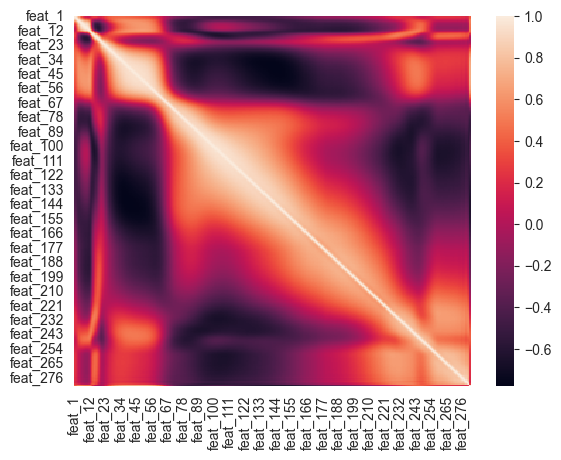

In [7]:
sns.heatmap(full_df.corr())

In [8]:
full_df['class'] = np.where(~full_df['class'].isin([1, 3]), 2, full_df['class'])

In [9]:
cat_features = []

In [10]:
numeric_features = full_df.columns

In [11]:
# model_cicids = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
# param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

              precision    recall  f1-score   support

           1       0.88      0.94      0.91      5842
           2       0.77      0.66      0.71      1579
           3       1.00      0.99      0.99     54903

    accuracy                           0.98     62324
   macro avg       0.88      0.86      0.87     62324
weighted avg       0.98      0.98      0.98     62324

Accuracy: 0.978483409280534


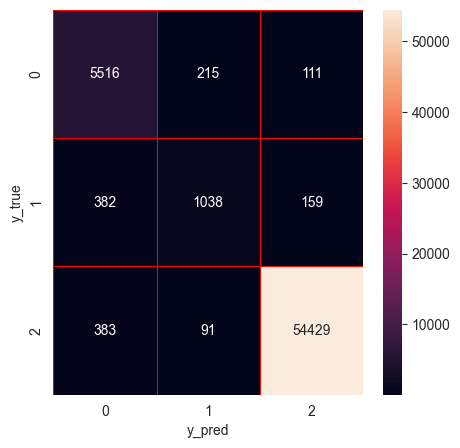

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = full_df.drop(['class'],axis=1)
y = full_df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.2, test_size = 0.8, shuffle=False, random_state = 0)

# # LightGBM algorithm
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [13]:
top_feats_df = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns.tolist()}).sort_values(by="Value",ascending=False)

In [14]:
top_feats_df

,Value,Feature
0,256,feat_1
7,221,feat_8
11,206,feat_12
3,187,feat_4
34,184,feat_35
...,...,...
219,3,feat_220
220,3,feat_221
270,2,feat_271
266,1,feat_267


In [15]:
top_feats = top_feats_df.Feature.tolist() #top_feats = top_feats_df.Feature.tolist() #

In [16]:
full_df_reduced = full_df[top_feats]

In [17]:
column_mapping_adult = {
    "target": "class",
    "numerical_features": full_df_reduced.columns,
    "categorical_features": [],
}

In [18]:
CT_dataset = Dataset(
    full_df=full_df_reduced, column_mapping=column_mapping_adult, window_size=1500 * 2, reference_size=10000
)

In [19]:
CT_dataset.full_df

,feat_1,feat_8,feat_12,feat_4,feat_35,feat_7,feat_3,feat_9,feat_6,feat_14,...,feat_256,feat_111,feat_234,feat_177,feat_193,feat_220,feat_221,feat_271,feat_267,feat_265
0,-0.583660,-1.50040,-2.26940,-1.00280,2.187800,-1.43060,-1.06650,-1.81840,-1.09060,-0.48698,...,0.736360,-0.50846,0.59253,-0.120510,-0.058840,0.318080,0.340520,-2.790100,-1.745000,-0.549050
1,-0.472420,-0.58362,-0.63163,-0.52436,-0.715300,-0.56987,-0.50777,-0.59666,-0.55541,-0.65154,...,2.012900,-0.43585,1.08100,-0.567920,-0.307640,0.515840,0.553980,2.582800,2.440600,2.366600
2,-0.841230,-1.20930,1.15110,-0.88060,-2.404800,-1.20550,-0.60240,-0.82451,-0.89159,1.17680,...,-0.249470,0.91527,-0.12657,0.209910,0.208350,-0.028353,-0.048506,-0.307660,-0.324280,-0.318010
3,-0.784450,-1.11380,1.22910,-0.80738,-2.397200,-1.10290,-0.63747,-0.77736,-0.87697,1.11500,...,-0.141620,1.31660,-0.10837,0.138440,0.061417,-0.049039,-0.043437,-0.131310,-0.141290,-0.152260
4,-0.803560,-0.07803,1.09970,-1.01080,-2.610900,-0.94300,-0.76955,0.71332,-1.30290,0.74887,...,-0.418260,1.01900,-0.31246,0.352300,0.207270,-0.094090,-0.102120,-0.322080,-0.351330,-0.370570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77899,0.631060,3.30950,5.51970,1.13200,0.022763,2.58450,0.84225,4.09030,1.93090,5.58540,...,-0.056169,-0.70172,0.24684,0.073093,-0.133390,-0.100380,-0.100790,0.071126,-0.000687,-0.014166
77900,0.059665,2.94730,4.93620,0.62163,-0.488030,2.19410,0.35738,3.71320,1.53410,4.93720,...,0.461910,-0.87522,0.77740,0.510970,0.184410,0.292950,0.310290,0.551000,0.496760,0.485010
77901,0.478810,3.74530,5.60520,1.22040,-0.098540,2.96800,0.83665,4.45670,2.20450,5.18660,...,-0.021201,-0.83170,0.33703,0.330250,0.052953,-0.003600,-0.000416,-0.042624,-0.072743,-0.065890
77902,0.584420,3.61170,5.37250,1.19610,-0.173430,2.82180,0.90344,4.29180,2.19560,5.18930,...,0.040737,-0.91804,0.57379,0.349610,-0.076125,0.152300,0.188720,0.114550,0.060130,0.048681


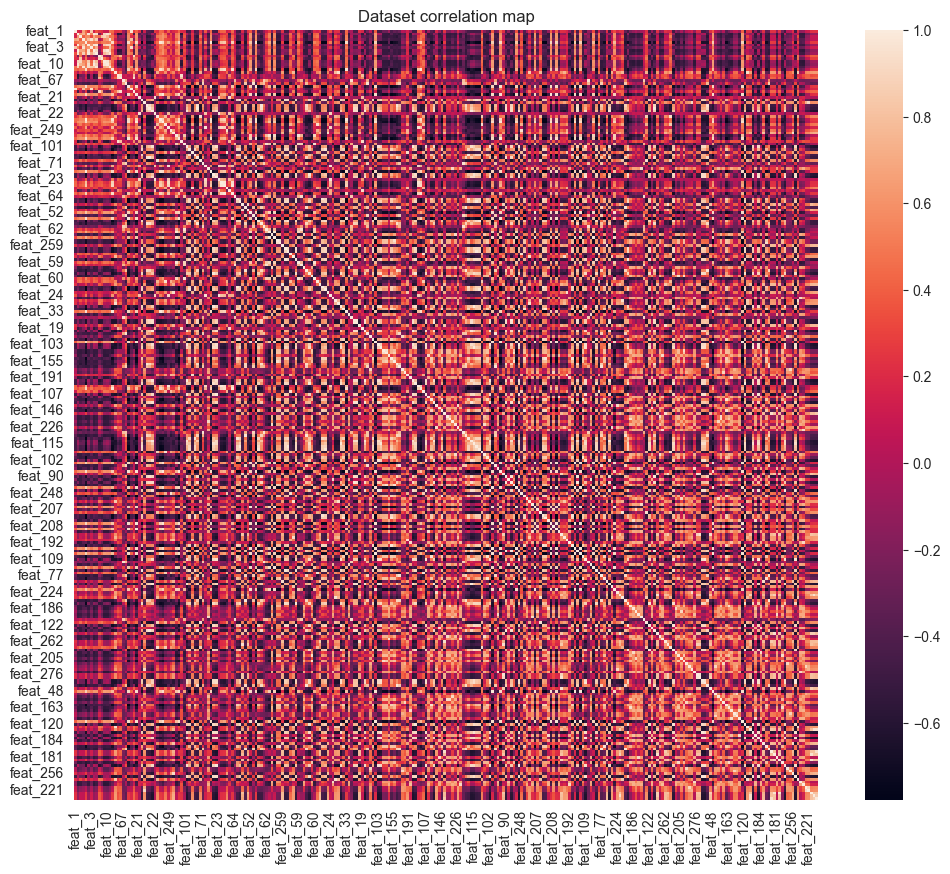

In [20]:
plt.figure(figsize=(12,10))
sns.heatmap(CT_dataset.full_df.corr(), annot=False)

plt.title('Dataset correlation map')
plt.show()

## Run Experiments

In [21]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [22]:
def plot_windowed_correlation(corr_dict, vertical_lines=None):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [23]:
#corr_dict = windowed_correlation(CT_dataset.full_df.loc[:, CT_dataset.full_df.columns], mode='expanding')

In [24]:
#plot_windowed_correlation(corr_dict)

In [25]:
column_names = list(CT_dataset.reference_df.columns)

In [26]:
len(column_names)

282

In [34]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num',
    continuous_methods=['jensen_shannon'],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=1000,
)

calc.fit(CT_dataset.reference_df)

In [35]:
results = calc.calculate(CT_dataset.analysis_df)

In [36]:
results_js = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]

In [37]:
display(results_js.iloc[18:21])

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,feat_1_jensen_shannon_value,feat_1_jensen_shannon_upper_threshold,feat_1_jensen_shannon_lower_threshold,...,feat_267_jensen_shannon_lower_threshold,feat_267_jensen_shannon_alert,feat_265_jensen_shannon_value,feat_265_jensen_shannon_upper_threshold,feat_265_jensen_shannon_lower_threshold,feat_265_jensen_shannon_alert,sample_num_jensen_shannon_value,sample_num_jensen_shannon_upper_threshold,sample_num_jensen_shannon_lower_threshold,sample_num_jensen_shannon_alert
18,[18000:18999],18,18000,18999,None,None,analysis,0.613521,0.1,None,...,None,True,0.421134,0.1,None,True,1.0,0.1,None,True
19,[19000:19999],19,19000,19999,None,None,analysis,0.525774,0.1,None,...,None,True,0.394708,0.1,None,True,1.0,0.1,None,True
20,[20000:20999],20,20000,20999,None,None,analysis,0.385488,0.1,None,...,None,True,0.293706,0.1,None,True,1.0,0.1,None,True


In [38]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]]

,feat_1_jensen_shannon_value,feat_8_jensen_shannon_value,feat_12_jensen_shannon_value,feat_4_jensen_shannon_value,feat_35_jensen_shannon_value,feat_7_jensen_shannon_value,feat_3_jensen_shannon_value,feat_9_jensen_shannon_value,feat_6_jensen_shannon_value,feat_14_jensen_shannon_value,...,feat_111_jensen_shannon_value,feat_234_jensen_shannon_value,feat_177_jensen_shannon_value,feat_193_jensen_shannon_value,feat_220_jensen_shannon_value,feat_221_jensen_shannon_value,feat_271_jensen_shannon_value,feat_267_jensen_shannon_value,feat_265_jensen_shannon_value,sample_num_jensen_shannon_value
0,0.158438,0.139161,0.342409,0.176123,0.255883,0.144556,0.163674,0.138557,0.156981,0.198081,...,0.284344,0.152918,0.318212,0.306519,0.239829,0.240894,0.171249,0.208526,0.215597,0.99812
1,0.119015,0.303368,0.396804,0.268227,0.264852,0.315254,0.221516,0.266805,0.302830,0.348997,...,0.213567,0.177312,0.416010,0.410507,0.324518,0.321890,0.141884,0.182684,0.192368,1.00000
2,0.145095,0.271393,0.310278,0.231747,0.259978,0.273808,0.192943,0.240518,0.273968,0.264305,...,0.167967,0.160987,0.337764,0.333484,0.291284,0.283519,0.186162,0.217424,0.234550,1.00000
3,0.121566,0.363453,0.302953,0.220135,0.200709,0.338967,0.152155,0.358914,0.305758,0.371131,...,0.201910,0.160474,0.265222,0.270196,0.205324,0.198886,0.124902,0.159669,0.186341,1.00000
4,0.158688,0.386866,0.307769,0.225561,0.163495,0.360810,0.155560,0.393552,0.324768,0.398349,...,0.220385,0.167357,0.215625,0.218652,0.155552,0.148050,0.126760,0.130845,0.144421,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.634465,0.895449,0.814167,0.322959,0.631899,0.836361,0.216397,0.924178,0.732935,0.641111,...,0.961717,0.744538,0.642964,0.789186,0.815859,0.827188,0.779625,0.822355,0.826271,1.00000
63,0.608578,0.857186,0.771577,0.263956,0.621517,0.800035,0.187752,0.901771,0.694570,0.641987,...,0.925066,0.679241,0.660862,0.733136,0.740350,0.749829,0.762810,0.793632,0.804826,1.00000
64,0.545794,0.875575,0.754251,0.407344,0.632950,0.831793,0.250843,0.906460,0.752558,0.655573,...,0.857814,0.672076,0.606865,0.711247,0.723135,0.731202,0.702388,0.721916,0.738582,1.00000
65,0.540790,0.893757,0.785907,0.371660,0.551426,0.845275,0.201330,0.933983,0.751376,0.783948,...,0.967827,0.747966,0.579807,0.713766,0.775899,0.792834,0.742031,0.769916,0.784976,1.00000


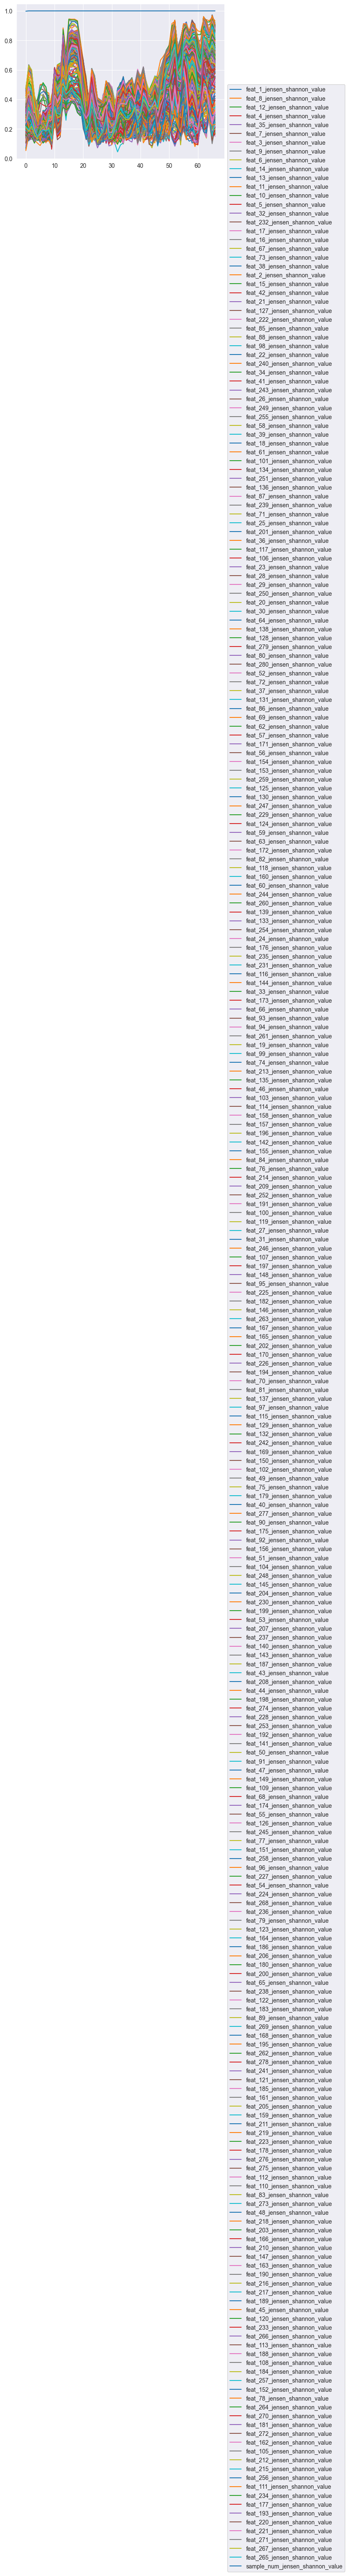

In [39]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]].plot()
plt.legend(bbox_to_anchor=(1, 0.5))

In [40]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

In [41]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### Own Jensen-Shannon

In [54]:
chg_points = [10000, 45000]

In [55]:
CT_dataset.add_changepoints(chg_points)

In [56]:
rad_left = 5000
rad_right = 5000

In [59]:
max_js_score = []
for i in range(1000, 72000, 1000):
    chg_points = [i]
    CT_dataset.add_changepoints(chg_points)
    rad_left = 1000
    rad_right = 1000

    dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
    dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)

    mx = dde_exp_eq_radius.results_all[dde_exp_eq_radius.results_all.columns[3:-1]].iloc[0].max()
    max_js_score.append(mx)

0 1000 2000
1000 2000 3000
2000 3000 4000
3000 4000 5000
4000 5000 6000
5000 6000 7000
6000 7000 8000
7000 8000 9000
8000 9000 10000
9000 10000 11000
10000 11000 12000
11000 12000 13000
12000 13000 14000
13000 14000 15000
14000 15000 16000
15000 16000 17000
16000 17000 18000
17000 18000 19000
18000 19000 20000
19000 20000 21000
20000 21000 22000
21000 22000 23000
22000 23000 24000
23000 24000 25000
24000 25000 26000
25000 26000 27000
26000 27000 28000
27000 28000 29000
28000 29000 30000
29000 30000 31000
30000 31000 32000
31000 32000 33000
32000 33000 34000
33000 34000 35000
34000 35000 36000
35000 36000 37000
36000 37000 38000
37000 38000 39000
38000 39000 40000
39000 40000 41000
40000 41000 42000
41000 42000 43000
42000 43000 44000
43000 44000 45000
44000 45000 46000
45000 46000 47000
46000 47000 48000
47000 48000 49000
48000 49000 50000
49000 50000 51000
50000 51000 52000
51000 52000 53000
52000 53000 54000
53000 54000 55000
54000 55000 56000
55000 56000 57000
56000 57000 58000
5700

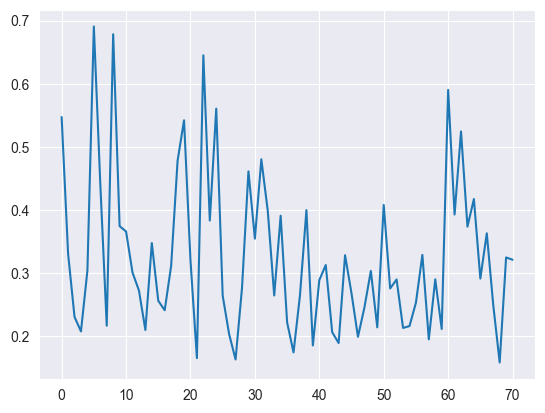

In [60]:
plt.plot(max_js_score)

In [90]:
chg_points = [22500, 60000]
CT_dataset.add_changepoints(chg_points)
rad_left = 5000
rad_right = 5000

In [91]:
dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)
display(dde_exp_eq_radius.results_all)

17500 22500 27500
55000 60000 65000


,start,change_point,end,feat_1,feat_8,feat_12,feat_4,feat_35,feat_7,feat_3,...,feat_111,feat_234,feat_177,feat_193,feat_220,feat_221,feat_271,feat_267,feat_265,sample_num
0,17500,22500,27500,0.352535,0.583307,0.489860,0.467769,0.491219,0.557477,0.443156,...,0.546669,0.342187,0.473929,0.498305,0.224537,0.232035,0.337992,0.332857,0.327166,0.999504
1,55000,60000,65000,0.272121,0.430854,0.484748,0.202848,0.361861,0.386537,0.134920,...,0.531929,0.287957,0.305092,0.382522,0.397004,0.367199,0.405550,0.429095,0.432803,0.999504


In [129]:
dde_exp_eq_radius.changepoint_radius_corr(radius_left=rad_left, radius_right=rad_right)

17500 22500 27500
55000 60000 65000


#### Change point 1

In [151]:
with pd.ExcelWriter(f'outputs/heartbeats/CD_delta_vs_ro_chp_tabs.xlsx') as writer:

    for chp in CT_dataset.change_points:
        drift_threshold = 0.4
        summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'ref_corr', 'analysis_corr', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

        corr_df_delta = dde_exp_eq_radius.corr_scores[chp]['corr_delta']
        corr_df_analysis = dde_exp_eq_radius.corr_scores[chp]['analysis']
        corr_df_ref = dde_exp_eq_radius.corr_scores[chp]['reference']

        cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

        for pair in itertools.combinations(dde_exp_eq_radius.dataset.full_df.columns, 2):
            feat1 = list(pair)[0]
            feat2 = list(pair)[1]

            if feat1 != feat2:
                summary_df.loc[len(summary_df.index)] = [feat1, feat2, np.abs(corr_df_ref.loc[feat1, feat2]), np.abs(corr_df_analysis.loc[feat1, feat2]), corr_df_delta.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

        summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
        summary_df['single_feat_drift'] = np.where(summary_df['feat_1_drift'] ^ summary_df['feat_2_drift'], 1, 0)
        summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)

        summary_df.to_excel(writer, sheet_name=f'{chp}', index=False)

In [152]:
summary_df = summary_df.sort_values(by=['feat_1_cd_score'], ascending=False)

In [153]:
summary_df

,feat_1,feat_2,ref_corr,analysis_corr,corr_delta,feat_1_cd_score,feat_2_cd_score,delta_cd_score,feat_1_drift,feat_2_drift,single_feat_drift,feat_pair_drift
38982,feat_105,feat_212,0.265518,0.448146,0.182628,0.542575,0.402023,0.140552,1,1,0,1
38993,feat_105,feat_265,0.373086,0.558189,0.185103,0.542575,0.432803,0.109772,1,1,0,1
38985,feat_105,feat_111,0.754923,0.904612,0.149689,0.542575,0.531929,0.010646,1,1,0,1
38986,feat_105,feat_234,0.341587,0.588953,0.247366,0.542575,0.287957,0.254618,1,0,1,0
38987,feat_105,feat_177,0.295387,0.066164,0.229223,0.542575,0.305092,0.237483,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
38976,feat_162,feat_193,0.161452,0.361087,0.199635,0.125648,0.382522,0.256875,0,0,0,0
38981,feat_162,feat_265,0.104913,0.188641,0.293554,0.125648,0.432803,0.307155,0,1,1,0
38978,feat_162,feat_221,0.132296,0.030365,0.162661,0.125648,0.367199,0.241551,0,0,0,0
38979,feat_162,feat_271,0.081556,0.174183,0.255739,0.125648,0.405550,0.279902,0,1,1,0


In [154]:
summary_df.feat_pair_drift.sum()

3828

In [155]:
def get_roc_auc(scores, ys):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [156]:
def plot_lift_curve(y_pred, y_val, step=0.01):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [157]:
score = summary_df.ref_corr #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

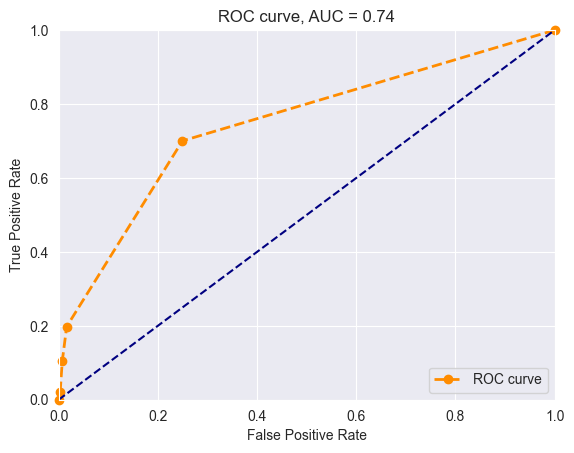

In [158]:
get_roc_auc(score, y)

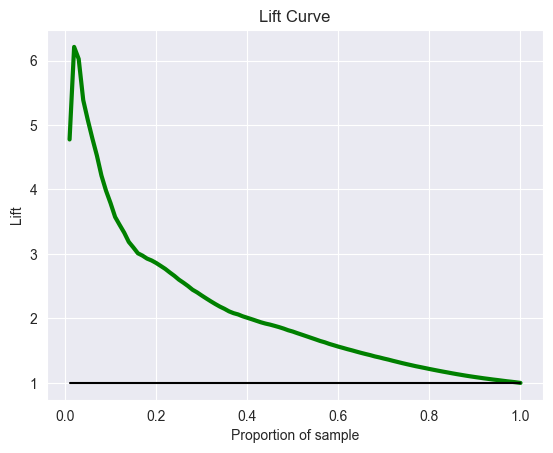

In [159]:
plot_lift_curve(score, y)

### DDE calculations

In [ ]:
# summary_df

In [ ]:
# m = 200
# k_dde = (summary_df.feat_1_drift.sum() + summary_df.feat_2_drift.sum()) / (m-1)

In [ ]:
# k_dde

In [ ]:
# dde_df = pd.DataFrame()

In [ ]:
# dde_df['threshold'] = np.arange(0,1,0.1)

In [ ]:
# dde_df['num_corr_feat_pairs'] = dde_df.threshold.map(lambda t: summary_df[summary_df['ref_corr']>=t].shape[0])
# dde_df['num_drifting_feat_pairs'] = dde_df.threshold.map(lambda t: summary_df[summary_df['ref_corr']>=t].feat_pair_drift.sum())
# dde_df['dde_pr'] = m/k_dde * dde_df['num_drifting_feat_pairs']/dde_df['num_corr_feat_pairs']
# dde_df['dde_lift'] = dde_df['dde_pr'] / dde_df.iloc[0].dde_pr

In [ ]:
# dde_df

In [ ]:
# dde_df[['dde_pr', 'dde_lift']].plot()

In [ ]:
# dde_fitted_coeffs = np.polyfit(dde_df.threshold, dde_df.dde_lift, 2)
# dde_fitted_curve = np.poly1d(dde_fitted_coeffs)

In [ ]:
# plt.plot(dde_df.threshold, dde_df.dde_lift, 'o', dde_df.threshold, dde_fitted_curve(dde_df.threshold))
# plt.show()

Excel ROC AUC calculations

In [ ]:
# excel_data = pd.read_excel(r'C:\Users\MarcellNemeth\Documents\BME\phd\meresek\insects\CD_delta_vs_ro_chp_tabs_insects_drift1.xlsx', sheet_name='ROC_output')

In [ ]:
# excel_data

In [ ]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

In [ ]:
# # calculate roc curves
# fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_10'])
# auc = roc_auc_score(excel_data['real'], excel_data['check_10'])
#
# # calculate AUC
# plt.plot(fpr, tpr, marker='.', label='DDE method')
# print('AUC: %.3f' % auc)

In [ ]:
# # calculate roc curves
# fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_5'])
# auc = roc_auc_score(excel_data['real'], excel_data['check_5'])
#
# # calculate AUC
# plt.plot(fpr, tpr, marker='.', label='DDE method')
# print('AUC: %.3f' % auc)

In [ ]:
# # calculate roc curves
# fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_3'])
# auc = roc_auc_score(excel_data['real'], excel_data['check_3'])
#
# # calculate AUC
# plt.plot(fpr, tpr, marker='.', label='DDE method')
# print('AUC: %.3f' % auc)

Crossvalidation of feature drift prediction

In [165]:
# import random

In [160]:
# d2_data = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\heartbeats\CD_delta_vs_ro_chp_tabs_heartbeats.xlsx', sheet_name='d2')

In [161]:
# drift_gt = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\heartbeats\CD_delta_vs_ro_chp_tabs_heartbeats.xlsx', sheet_name='drift_gt2')

In [162]:
# drift_gt = drift_gt.set_index('feature')

In [169]:
# all_feats = [f'feat_{f}' for f in range(1, 281)]
#
# k_fold = 5
# max_num_check_feats = 270

In [170]:
# cross_metrics = pd.DataFrame(index=pd.Index(all_feats))
# cross_metrics = cross_metrics.merge(drift_gt, left_index=True, right_index=True)
#
# for num_check_feats in range(1, max_num_check_feats+1):
#     for k in range(k_fold):
#         check_feats = [f'feat_{r}' for r in random.sample(range(1, 281), num_check_feats)]
#         filt_data = d2_data[(d2_data['feature_1'].isin(check_feats))]
#
#         dde_agg = filt_data.groupby('feature_2').agg({'feat2_drift_prob_local': 'sum'}).reset_index()
#         dde_agg = dde_agg.rename(columns={'feat2_drift_prob_local': f'chkfts{num_check_feats}_fold{k+1}'})
#         dde_agg = dde_agg.set_index('feature_2')
#
#         cross_metrics = cross_metrics.merge(dde_agg, left_index=True, right_index=True, how='left')
#         #cross_metrics = cross_metrics.fillna(cross_metrics.mean())

In [171]:
# cross_metrics

,drift_true,chkfts1_fold1,chkfts1_fold2,chkfts1_fold3,chkfts1_fold4,chkfts1_fold5,chkfts2_fold1,chkfts2_fold2,chkfts2_fold3,chkfts2_fold4,...,chkfts269_fold1,chkfts269_fold2,chkfts269_fold3,chkfts269_fold4,chkfts269_fold5,chkfts270_fold1,chkfts270_fold2,chkfts270_fold3,chkfts270_fold4,chkfts270_fold5
feat_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.397778,14.664102,14.671058,13.196416,14.663472,14.661264,15.397778,13.935879,13.938140,14.661264
feat_3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.379498,4.379498,3.655173,3.655173,3.643992,4.379498,4.379498,3.651636,3.651799,4.379498
feat_4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.194570,2.194570,2.194570,2.194570,1.457593,2.194570,2.194570,2.194570,1.463236,2.194570
feat_5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.467505,9.467505,8.743272,8.743272,8.728745,9.467505,9.467505,8.018939,8.008480,9.467505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feat_276,0,0.734041,0.737166,0.730992,0.730459,NaN,0.731029,1.470974,0.739461,0.732733,...,164.693417,165.409850,163.928099,164.683377,165.406648,164.675318,165.408722,166.132037,166.143731,166.886898
feat_277,0,0.733360,0.737291,0.730133,0.729722,NaN,0.730216,0.731436,0.738696,0.732336,...,115.407255,114.669838,113.927461,113.942198,113.201600,113.931553,113.932441,112.450699,113.194217,114.675625
feat_278,0,0.733452,0.737628,0.730556,0.730289,NaN,0.730721,1.471442,0.738578,0.732753,...,158.056413,157.303669,155.820708,156.578925,158.778638,156.571022,158.039918,158.024728,158.038493,158.782093
feat_279,0,0.733692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.733351,...,44.893714,44.159239,44.892550,43.429282,45.634934,44.893658,45.629538,42.683688,43.423654,44.900724


In [ ]:
# cross_preds = pd.DataFrame(index=pd.Index(all_feats))
# cross_preds = cross_preds.merge(drift_gt, left_index=True, right_index=True)
#
# for num_check_feats in range(1, max_num_check_feats + 1):
#     for k in range(k_fold):
#         check_feats = [f'feat_{r}' for r in random.sample(range(1, 200), num_check_feats)]
#         filt_data = d2_data[(d2_data['feature_1'].isin(check_feats))]
#
#         dde_agg = filt_data.groupby('feature_2').agg({'feat_1_drift': 'mean'}).reset_index()
#         dde_agg = dde_agg.rename(columns={'feat_1_drift': f'chkfts{num_check_feats}_fold{k + 1}'})
#         dde_agg[f'chkfts{num_check_feats}_fold{k + 1}'] = dde_agg[f'chkfts{num_check_feats}_fold{k + 1}'].map(lambda x: 1 if x >= 0.5 else 0)
#
#         dde_agg = dde_agg.set_index('feature_2')
#
#         cross_preds = cross_preds.merge(dde_agg, left_index=True, right_index=True, how='left')

In [ ]:
# cross_preds = cross_preds.fillna(0).rename(columns={'drift_true': 'drift_gt'}) #.drop(columns=['drift_true'])

In [ ]:
# cross_preds

In [ ]:
# idx = cross_preds.columns.str.split('_', expand=True)

In [ ]:
# cross_preds.columns = pd.MultiIndex.from_tuples(idx)

In [ ]:
# cross_preds

In [ ]:
# preds_agg = pd.DataFrame(columns=cross_preds.columns[1:], index=pd.Index(pd.Series(['AUC'])))

In [ ]:
# preds_agg

In [ ]:
# for num_check_feats in range(1, max_num_check_feats + 1):
#     for k in range(k_fold):
#         # print(roc_auc_score(cross_preds['drift']['gt'], cross_preds[f'chkfts{num_check_feats}'][f'fold{k+1}']))
#         auc = roc_auc_score(cross_preds['drift']['gt'], cross_preds[f'chkfts{num_check_feats}'][f'fold{k+1}'])
#         preds_agg.loc['AUC', (f'chkfts{num_check_feats}', f'fold{k+1}')] = auc

In [ ]:
# preds_agg.mean(level=0, axis='columns').T.plot()

### Cross validation test on Excel extract

In [183]:
import random

In [184]:
from sklearn.metrics import roc_auc_score, roc_curve

In [185]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    print(f'model 1 AUC score: {roc_auc_score(true_y, y_prob)}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [186]:
d2_df = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\heartbeats\CD_delta_vs_ro_chp_tabs_heartbeats.xlsx', sheet_name='d2')
feat_1_drift_gt = d2_df.groupby('feature_1').agg({'feat_1_drift': 'max'}).rename(columns={'feat_1_drift': 'drift_gt'})

In [189]:
feat_1_drift_gt

,drift_gt
feature_1,
feat_1,0
feat_10,1
feat_100,1
feat_101,1
feat_102,1
...,...
feat_95,1
feat_96,1
feat_97,1


In [209]:
measurement_df = pd.DataFrame(index=pd.Index(pd.Series(['f1_score'])))
measurement_df_probs = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))
measurement_df_ddescore = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))

In [210]:
max_num_chkfts = 279
num_kfold = 20

In [211]:
for num_chkfts in range(1, max_num_chkfts+1):
    for k in range(1, num_kfold+1):
        feats_check = [f'feat_{r}' for r in random.sample(range(1, max_num_chkfts+1), num_chkfts)]
        d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

        d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum', 'feat2_drift_prob_local': 'sum'})

        d2_df_filt_agg['pred_prob'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: x/num_chkfts)
        d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x / num_chkfts >= 0.5 else 0)

        feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred', 'pred_prob', 'feat2_drift_prob_local']], left_index=True, right_index=True, how='left')
        feat_1_drift_gt = feat_1_drift_gt.fillna(0)


        feat_1_drift_gt.sort_values(by='feat2_drift_prob_local', ascending=False, inplace=True)

        measurement_df[f'chkfeats{num_chkfts}_fold{k}'] = f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'])
        measurement_df_probs[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred_prob'])
        measurement_df_ddescore[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['feat2_drift_prob_local'])


        #plot_roc_curve(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred_prob'])

        feat_1_drift_gt = feat_1_drift_gt.drop(columns=['pred', 'pred_prob', 'feat2_drift_prob_local'])

In [212]:
idx = measurement_df.columns.str.split('_', expand=True)
measurement_df.columns = pd.MultiIndex.from_tuples(idx)

idx_probs = measurement_df_probs.columns.str.split('_', expand=True)
measurement_df_probs.columns = pd.MultiIndex.from_tuples(idx_probs)

idx_dde = measurement_df_ddescore.columns.str.split('_', expand=True)
measurement_df_ddescore.columns = pd.MultiIndex.from_tuples(idx_dde)

In [213]:
measurement_agg = pd.DataFrame()
measurement_agg['f1_avg'] = measurement_df.mean(level=0, axis='columns').T
measurement_agg['f1_std'] = measurement_df.std(level=0, axis='columns').T

measurement_agg_probs = pd.DataFrame()
measurement_agg_probs['auc_avg'] = measurement_df_probs.mean(level=0, axis='columns').T
measurement_agg_probs['auc_std'] = measurement_df_probs.std(level=0, axis='columns').T

measurement_agg_dde = pd.DataFrame()
measurement_agg_dde['auc_avg'] = measurement_df_ddescore.mean(level=0, axis='columns').T
measurement_agg_dde['auc_std'] = measurement_df_ddescore.std(level=0, axis='columns').T

<AxesSubplot:>

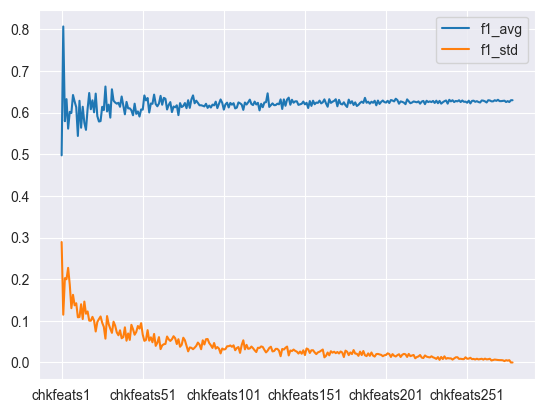

In [214]:
measurement_agg.plot()

<AxesSubplot:>

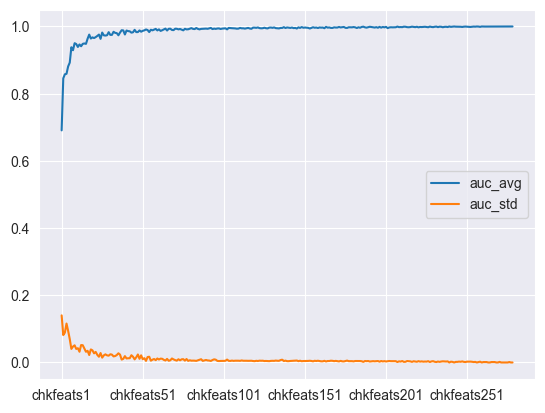

In [215]:
measurement_agg_probs.plot()

<AxesSubplot:>

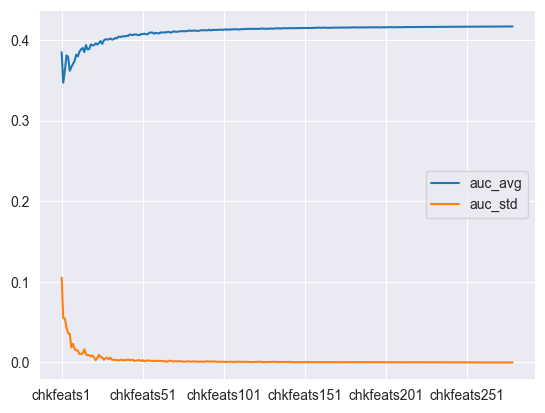

In [216]:
measurement_agg_dde.plot()

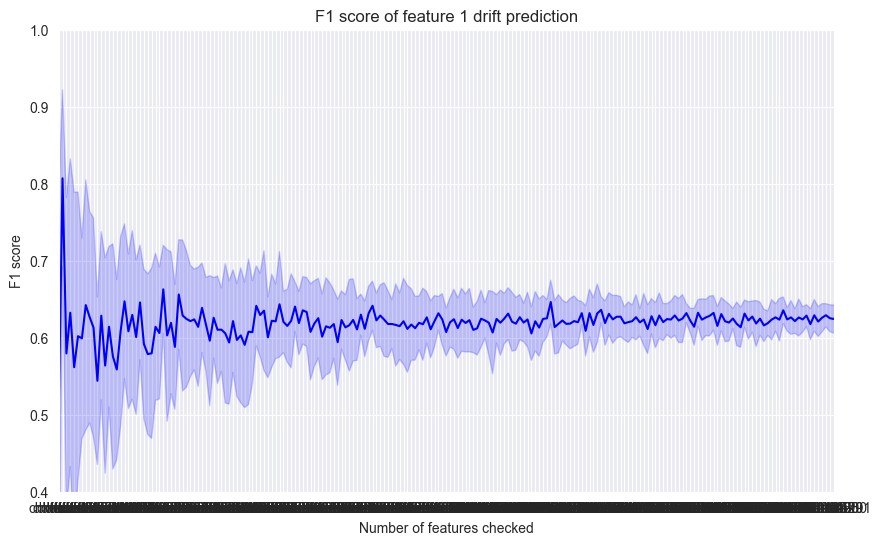

In [217]:
# plot mean with std on shaded area
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(measurement_agg['f1_avg'], color='blue')
ax.fill_between(measurement_agg.index, measurement_agg['f1_avg'] - measurement_agg['f1_std'], measurement_agg['f1_avg'] + measurement_agg['f1_std'], color='blue', alpha=0.2)
ax.set_xlabel('Number of features checked')
ax.set_ylabel('F1 score')
ax.set_title('F1 score of feature 1 drift prediction')
ax.set_ylim(0.4, 1)
ax.set_xlim(0, 200)
plt.show()